# Clustering

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn import mixture
from scipy.stats import mode
from tqdm import tqdm

### Baseline Model Kaggle Submission

In [2]:
# Reorder the laebl and format output for kaggle submission
def format_submission(df, label_col = "label"):
    df = df.sort_index()
    df = pd.DataFrame(df[label_col])
    label_mapping = {}
    activtyID_list = []
    raw_label = df[label_col].tolist()
    for l in raw_label:
        if len(label_mapping) == 0:
            label_mapping[l] = 1 # Final label starts with 1
            activtyID_list.append(1)
        elif l not in label_mapping:
            label_mapping[l] = max(list(label_mapping.values())) + 1
            activtyID_list.append(label_mapping[l])
        else:
            activtyID_list.append(label_mapping[l])
    df["activityID"] = activtyID_list
    print(df)
    df.drop(label_col, axis=1, inplace=True)
    df.to_csv("../data/submission.csv", index=True, index_label=["Index"])

In [3]:
# Load the PCA-transformed data
pca_df = pd.read_pickle('../data/pca_df.pkl')
pca_df.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
54744,-0.391981,-0.072599,0.130924,0.097482,-0.067807,-0.006120,-0.011211
440445,-0.391892,0.000947,-0.003173,-0.002236,-0.000362,-0.000079,-0.004144
238954,-0.391889,-0.000039,0.000776,0.000887,-0.000132,-0.000006,0.000481
22854,-0.391887,0.000103,-0.000875,-0.001072,-0.001473,-0.000106,0.000182
366131,-0.391882,-0.000056,0.000174,0.000604,0.001054,0.000066,0.000543


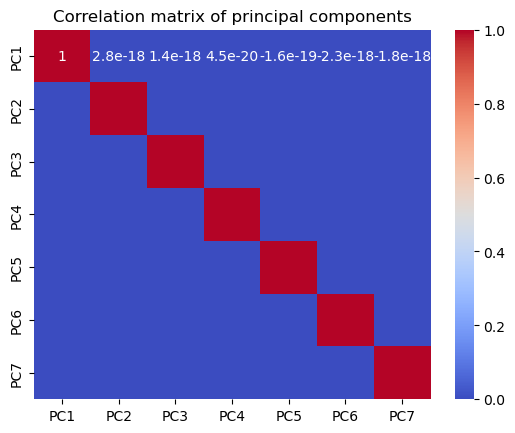

In [4]:
# Plot correlation matrix of principal components
corr_matrix = pca_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation matrix of principal components')
plt.show()

### KMeans

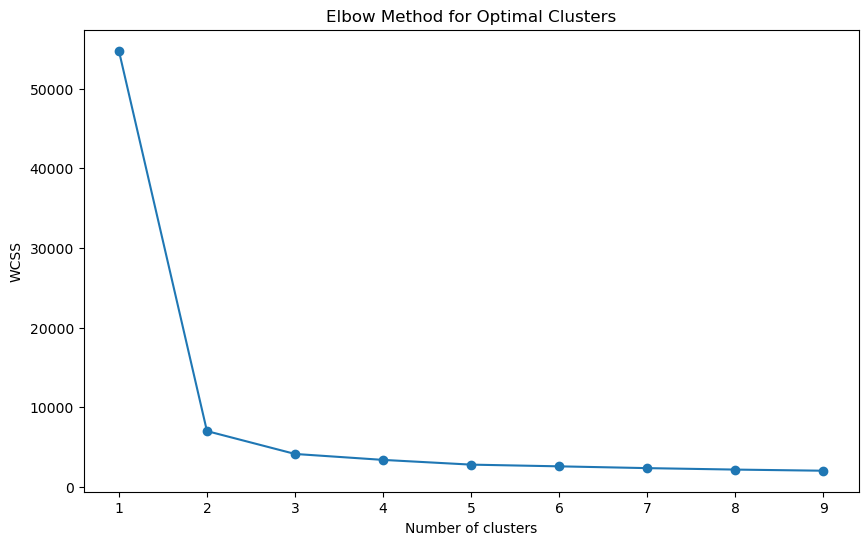

CPU times: user 1min 35s, sys: 15.5 s, total: 1min 50s
Wall time: 14.9 s


In [5]:
%%time

# Determine the optimal number of clusters using the Elbow Method
wcss = []  # Within-cluster sum of squares
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=0)
    kmeans.fit(pca_df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), wcss, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [6]:
%%time

from sklearn.metrics import silhouette_score

# Define the fraction of data to use (e.g., 0.1 for 10%)
sample_fraction = 0.1

# Sample a subset of the data
data_sample = pca_df.sample(frac=sample_fraction, random_state=42)

# Determine the optimal number of clusters using a data subset
best_score = -1
best_k = 0
range_n_clusters = list(range(2, 20))

# Loop through the range of cluster numbers with tqdm for progress bar
for n_clusters in tqdm(range_n_clusters, desc="Evaluating number of clusters"):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=0)
    cluster_labels = kmeans.fit_predict(data_sample)
    silhouette_avg = silhouette_score(data_sample, cluster_labels)
    print(f'k = {n_clusters} has Silhouette score {silhouette_avg}')
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_k = n_clusters

print(f"Optimal number of clusters: {best_k}, with silhouette score: {best_score}")

Evaluating number of clusters:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating number of clusters:   6%|▌         | 1/18 [00:35<10:11, 35.99s/it]

k = 2 has Silhouette score 0.7947943069785071


Evaluating number of clusters:  11%|█         | 2/18 [01:07<08:55, 33.47s/it]

k = 3 has Silhouette score 0.6936017407924202


Evaluating number of clusters:  17%|█▋        | 3/18 [01:39<08:12, 32.84s/it]

k = 4 has Silhouette score 0.5684230137631693


Evaluating number of clusters:  22%|██▏       | 4/18 [02:12<07:39, 32.81s/it]

k = 5 has Silhouette score 0.5463443556399084


Evaluating number of clusters:  28%|██▊       | 5/18 [02:43<06:56, 32.02s/it]

k = 6 has Silhouette score 0.5498651627151745


Evaluating number of clusters:  33%|███▎      | 6/18 [03:13<06:18, 31.54s/it]

k = 7 has Silhouette score 0.5529880095240766


Evaluating number of clusters:  39%|███▉      | 7/18 [03:44<05:45, 31.42s/it]

k = 8 has Silhouette score 0.5571824353331938


Evaluating number of clusters:  44%|████▍     | 8/18 [04:15<05:11, 31.11s/it]

k = 9 has Silhouette score 0.5385506888809298


Evaluating number of clusters:  50%|█████     | 9/18 [04:47<04:43, 31.55s/it]

k = 10 has Silhouette score 0.510001714981675


Evaluating number of clusters:  56%|█████▌    | 10/18 [05:18<04:10, 31.34s/it]

k = 11 has Silhouette score 0.511441472332025


Evaluating number of clusters:  61%|██████    | 11/18 [05:49<03:38, 31.26s/it]

k = 12 has Silhouette score 0.5134162813020964


Evaluating number of clusters:  67%|██████▋   | 12/18 [06:20<03:05, 30.98s/it]

k = 13 has Silhouette score 0.4898112791911027


Evaluating number of clusters:  72%|███████▏  | 13/18 [06:50<02:34, 30.84s/it]

k = 14 has Silhouette score 0.4947454965403751


Evaluating number of clusters:  78%|███████▊  | 14/18 [07:20<02:01, 30.49s/it]

k = 15 has Silhouette score 0.43322725018415004


Evaluating number of clusters:  83%|████████▎ | 15/18 [07:50<01:31, 30.46s/it]

k = 16 has Silhouette score 0.4080405939010688


Evaluating number of clusters:  89%|████████▉ | 16/18 [08:21<01:00, 30.47s/it]

k = 17 has Silhouette score 0.4385360318340615


Evaluating number of clusters:  94%|█████████▍| 17/18 [08:51<00:30, 30.47s/it]

k = 18 has Silhouette score 0.40424576299761794


Evaluating number of clusters: 100%|██████████| 18/18 [09:22<00:00, 31.26s/it]

k = 19 has Silhouette score 0.38666931644960234
Optimal number of clusters: 2, with silhouette score: 0.7947943069785071
CPU times: user 14min 50s, sys: 6min 57s, total: 21min 47s
Wall time: 9min 22s


In [7]:
%%time

from sklearn.metrics import calinski_harabasz_score

best_score = -np.inf
best_k = None
best_model = None
best_cluster_assignments = None

data_normalized = pca_df

# Loop through the range of k values with tqdm for progress bar
for k in tqdm(range(2, 20), desc="Evaluating number of clusters"):
    # Fit the KMeans model
    candidate_kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=0)
    candidate_kmeans.fit(data_normalized)
    
    # Predict the cluster assignments
    cluster_assignments = candidate_kmeans.predict(data_normalized)
    
    # Calculate the Calinski-Harabasz score
    score = calinski_harabasz_score(data_normalized, cluster_assignments)
    print(f'k = {k} has CH index {score}')
    
    # Check if the current score is the best
    if score > best_score:
        best_score = score
        best_k = k
        best_model = candidate_kmeans
        best_cluster_assignments = cluster_assignments

# Output the best number of clusters
print(f'Best k within 2, 3, ..., 19 according to CH index: {best_k}')

Evaluating number of clusters:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating number of clusters:   6%|▌         | 1/18 [00:00<00:12,  1.41it/s]

k = 2 has CH index 3636188.4350355305


Evaluating number of clusters:  11%|█         | 2/18 [00:01<00:12,  1.25it/s]

k = 3 has CH index 3261641.4753605025


Evaluating number of clusters:  17%|█▋        | 3/18 [00:02<00:13,  1.09it/s]

k = 4 has CH index 2689723.492032659


Evaluating number of clusters:  22%|██▏       | 4/18 [00:04<00:15,  1.11s/it]

k = 5 has CH index 2472527.0705490527


Evaluating number of clusters:  28%|██▊       | 5/18 [00:05<00:17,  1.36s/it]

k = 6 has CH index 2151022.076224024


Evaluating number of clusters:  33%|███▎      | 6/18 [00:08<00:20,  1.72s/it]

k = 7 has CH index 1970197.278479681


Evaluating number of clusters:  39%|███▉      | 7/18 [00:10<00:22,  2.03s/it]

k = 8 has CH index 1836403.2402982484


Evaluating number of clusters:  44%|████▍     | 8/18 [00:15<00:27,  2.75s/it]

k = 9 has CH index 1723974.612750726


Evaluating number of clusters:  50%|█████     | 9/18 [00:19<00:29,  3.25s/it]

k = 10 has CH index 1607684.2231398048


Evaluating number of clusters:  56%|█████▌    | 10/18 [00:24<00:30,  3.80s/it]

k = 11 has CH index 1537813.7674410962


Evaluating number of clusters:  61%|██████    | 11/18 [00:30<00:30,  4.32s/it]

k = 12 has CH index 1446728.6283283434


Evaluating number of clusters:  67%|██████▋   | 12/18 [00:35<00:28,  4.74s/it]

k = 13 has CH index 1401726.0555820237


Evaluating number of clusters:  72%|███████▏  | 13/18 [00:42<00:26,  5.28s/it]

k = 14 has CH index 1325533.659448996


Evaluating number of clusters:  78%|███████▊  | 14/18 [00:49<00:23,  5.92s/it]

k = 15 has CH index 1324484.0649640053


Evaluating number of clusters:  83%|████████▎ | 15/18 [00:57<00:19,  6.62s/it]

k = 16 has CH index 1274195.1012510234


Evaluating number of clusters:  89%|████████▉ | 16/18 [01:05<00:13,  6.99s/it]

k = 17 has CH index 1246228.8380887238


Evaluating number of clusters:  94%|█████████▍| 17/18 [01:14<00:07,  7.49s/it]

k = 18 has CH index 1198539.6641052873


Evaluating number of clusters: 100%|██████████| 18/18 [01:23<00:00,  4.66s/it]

k = 19 has CH index 1183553.8859433818
Best k within 2, 3, ..., 19 according to CH index: 2
CPU times: user 8min 21s, sys: 57.8 s, total: 9min 18s
Wall time: 1min 23s


In [8]:
# Helper function to get Betweenss (inter-cluster distance)
# def get_betweenss(cluster_model):
#     betweenss = 0
#     overall_mean = np.mean(pca_df, axis=0)
#     for i in range(cluster_model.n_clusters):
#         cluster_points = pca_df[cluster_model.labels_ == i]
#         cluster_mean = np.mean(cluster_points, axis=0)
#         cluster_size = len(cluster_points)
#         betweenss += cluster_size * np.sum((cluster_mean - overall_mean) ** 2)
#     return betweenss


In [9]:
# Calculate cohesion (the lower the better) and separation (the higher the better)
# def get_cohesion_and_separation(cluster_model):
#     betweenss = get_betweenss(cluster_model)
#     withinss = cluster_model.inertia_
#     return [withinss/(betweenss + withinss), betweenss/(betweenss + withinss)]

In [10]:
# Allow model comparison with different K values
# def compare_models(k_list):
#     model_list = []
#     for k in k_list:
#         kmeans = KMeans(n_clusters=k, random_state=42).fit(pca_df)
#         cohesion, separation = get_cohesion_and_separation(kmeans)
#         print(f"K = {k}, Cohesion = {round(cohesion, 3)}, Separation = {round(separation, 3)}")
#         model_list.append(kmeans)
#     return model_list

# compare_models([5, 10, 15, 20, 25, 30])


In [40]:
# Get baseline model and labeled data
kmeans = KMeans(n_clusters=4, random_state=42).fit(pca_df)
kmeans_labeled = pca_df.assign(label=kmeans.labels_)
kmeans_labeled.head(5)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,label
54744,-0.391981,-0.072599,0.130924,0.097482,-0.067807,-0.006120,-0.011211,3
440445,-0.391892,0.000947,-0.003173,-0.002236,-0.000362,-0.000079,-0.004144,3
238954,-0.391889,-0.000039,0.000776,0.000887,-0.000132,-0.000006,0.000481,3
22854,-0.391887,0.000103,-0.000875,-0.001072,-0.001473,-0.000106,0.000182,3
366131,-0.391882,-0.000056,0.000174,0.000604,0.001054,0.000066,0.000543,3


In [41]:
unique_clusters = kmeans_labeled['label'].unique()
print(f"Unique clusters: {unique_clusters}")

Unique clusters: [3 1 2 0]


In [42]:
format_submission(kmeans_labeled)

        label  activityID
0           3           1
1           0           2
2           1           3
3           0           2
4           3           1
...       ...         ...
534596      0           2
534597      2           4
534598      2           4
534599      0           2
534600      1           3

[534601 rows x 2 columns]


### GMM

In [14]:
from sklearn.mixture import GaussianMixture

# # Fit the GMM model
# gmm = GaussianMixture(n_components=4, covariance_type='full', n_init=10, random_state=42)
# gmm.fit(pca_df)

# # Predict cluster labels
# gmm_labels = gmm.predict(pca_df)

# # Assign labels to the data
# gmm_labeled = pca_df.assign(label=gmm_labels)
# gmm_labeled.head(5)

# # Print the random state of the model
# print(f"The random state of the model is {gmm.random_state}")

In [15]:
# format_submission(gmm_labeled)

### Bagging Kmeans

In [16]:
# n_clusters = 4
# n_bagging_iterations = 15

# # Initialize result array
# all_labels = np.zeros((pca_df.shape[0], n_bagging_iterations))

# for i in range(n_bagging_iterations):
#     # Construct the single kmeans model
#     pca_df_resampled = resample(pca_df, replace=True, n_samples=round(0.5 * pca_df.shape[0]), random_state=i)
#     kmeans = KMeans(n_clusters=n_clusters, random_state=i)
#     kmeans.fit(pca_df_resampled)
#     raw_label = kmeans.predict(pca_df)
#     label_mapping = {}
#     activtyID_list = []
#     # Reorder label to make it consistent across different interations
#     for l in raw_label:
#         if len(label_mapping) == 0:
#             label_mapping[l] = 1 # Final label starts with 1
#             activtyID_list.append(1)
#         elif l not in label_mapping:
#             label_mapping[l] = max(list(label_mapping.values())) + 1
#             activtyID_list.append(label_mapping[l])
#         else:
#             activtyID_list.append(label_mapping[l])
#     all_labels[:, i] = activtyID_list

# # Find the consensus label
# consensus_labels = np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=1, arr=all_labels)

In [17]:
# submission_df = pd.DataFrame(consensus_labels, index=range(len(pca_df)), columns=["activityID"])
# submission_df.to_csv("../data/submission_bagged.csv", index=True, index_label=["Index"])

### Boosting Kmeans

In [18]:
# n_clusters = 4
# n_boosting_iterations = 15
# sample_weights = np.ones(pca_df.shape[0])
# all_labels = np.zeros((pca_df.shape[0], n_boosting_iterations))

# for i in range(n_boosting_iterations):
#     # Construct the single kmeans model
#     kmeans = KMeans(n_clusters=n_clusters, random_state=i)
#     kmeans.fit(pca_df, sample_weight=sample_weights) # cluster based on the weight of data 
#     labels = kmeans.predict(pca_df)
#     label_mapping = {}
#     activtyID_list = []
#     # Reorder the label to make it consistent across iteration
#     for l in raw_label:
#         if len(label_mapping) == 0:
#             label_mapping[l] = 1 # Final label starts with 1
#             activtyID_list.append(1)
#         elif l not in label_mapping:
#             label_mapping[l] = max(list(label_mapping.values())) + 1
#             activtyID_list.append(label_mapping[l])
#         else:
#             activtyID_list.append(label_mapping[l])
#     all_labels[:, i] = activtyID_list
#     # Update sample weights based on consistency
#     for j in range(pca_df.shape[0]):
#         # Increase weight for points that were inconsistently clustered
#         if np.sum(all_labels[j, :i+1] == mode(all_labels[j, :i+1]).mode[0]) < (i + 1) / 2:
#             sample_weights[j] *= 1.1

# sample_weights /= np.sum(sample_weights)
# consensus_labels = mode(all_labels, axis=1).mode.flatten()

In [19]:
# submission_df = pd.DataFrame(consensus_labels, index=range(len(pca_df)), columns=["activityID"])
# submission_df["activityID"] = submission_df["activityID"].astype(int)
# submission_df.to_csv("../data/submission_boosted.csv", index=True, index_label=["Index"])